In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
!pip install pyarrow

In [149]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

In [150]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


In [151]:
# Read the data for January. How many records are there?

# 1154112

In [152]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [153]:
# What's the average trip duration in January?

# 1) difference between dropoff time and pickup time in minutes
df['trip_duration'] = (df.dropOff_datetime - df.pickup_datetime).dt.total_seconds() / 60

# 2) calculate average
avg_trip = round(df['trip_duration'].mean(),2)
avg_trip_duration = str(avg_trip) + " minutes"
print(avg_trip_duration)

19.17 minutes


In [154]:
# Check the distribution of the duration variable. There are some outliers.

# sns.distplot(df.trip_duration)
# df.trip_duration.describe()

df.trip_duration.describe(percentiles = [0.95, 0.98, 0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: trip_duration, dtype: float64

In [155]:
# Percent of trips between 1 and 60 minutes

((df.trip_duration >= 1) & (df.trip_duration <= 60)).mean()

0.9616276409915155

In [156]:
# Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

df = df[df['trip_duration'].between(1, 60, inclusive = 'both')]
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,trip_duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [157]:
# How many records did you drop?

no_dropped_records = 1154112 - len(df)
no_dropped_records

44286

In [158]:
df[['DOlocationID', 'PUlocationID']] = df[['DOlocationID', 'PUlocationID']].fillna(-1)

# df = df[df['DOlocationID'].fillna(-1)]
# df.loc[:, ['DOlocationID', 'PUlocationID']]  = df[['DOlocationID', 'PUlocationID']].fillna(-1)
# df.loc[:, ['DOlocationID', 'PUlocationID']].fillna(-1) 
df

/tmp/ipykernel_2834/2556675395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['DOlocationID', 'PUlocationID']] = df[['DOlocationID', 'PUlocationID']].fillna(-1)


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,trip_duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [159]:
# What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs

df['PUlocationID'].value_counts(normalize = True) * 100

# 83%

-1.0      83.527328
 221.0     0.750568
 206.0     0.612438
 129.0     0.484671
 115.0     0.367805
            ...    
 111.0     0.000451
 27.0      0.000360
 34.0      0.000270
 2.0       0.000180
 110.0     0.000090
Name: PUlocationID, Length: 262, dtype: float64

In [160]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,trip_duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [161]:
categorical = ['PUlocationID','DOlocationID']
numerical = ['trip_duration']
df[categorical].dtypes

PUlocationID    float64
DOlocationID    float64
dtype: object

In [197]:
df[categorical] = df.loc[:, categorical].astype(str)
# df[categorical].astype(str).dtypes

/tmp/ipykernel_2834/3780818825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df.loc[:, categorical].astype(str)


In [199]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
trip_duration                    float64
dtype: object

In [200]:
# Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

# Turn the dataframe into a list of dictionaries
train_dicts = df[categorical].to_dict(orient = 'records')

In [201]:
# Fit a dictionary vectorizer

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [202]:
# What's the dimensionality of this matrix? (The number of columns).

X_train.shape

(1109826, 525)

In [203]:
# Now let's use the feature matrix from the previous step to train a model.

# Train a plain linear regression model with default parameters
# Calculate the RMSE of the model on the training data
# What's the RMSE on train?

# 5.52
# 10.52
# 15.52
# 20.52

In [204]:
target = 'trip_duration'
y_train = df[target].values
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [205]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [206]:
y_pred = lr.predict(X_train)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


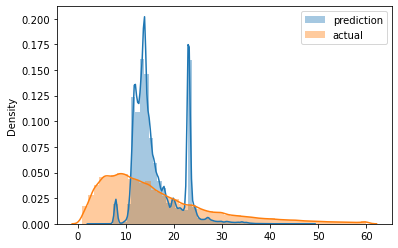

In [207]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [208]:
# model incorrect by an average of (minutes): 

mean_squared_error(y_train, y_pred, squared = False) 

10.528519107212292

In [210]:
# Pre-processing of the df

def read_dataframe(filename):

    df = pd.read_parquet(filename)
    
    df['trip_duration'] = (df.dropOff_datetime - df.pickup_datetime).dt.total_seconds() / 60
    df = df[df['trip_duration'].between(1, 60, inclusive = 'both')]
    df[['DOlocationID', 'PUlocationID']] = df[['DOlocationID', 'PUlocationID']].fillna(-1)

    categorical = ['PUlocationID','DOlocationID']
    df[categorical] = df.loc[:, categorical].astype(str)
    
    return df

In [211]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [212]:
len(df_train), len(df_val)

(1109826, 990113)

In [213]:
# training pipeline

categorical = ['PUlocationID','DOlocationID']
numerical = ['trip_duration']

dv = DictVectorizer()

train_dicts = df[categorical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [214]:
target = 'trip_duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False) 